<a href="https://colab.research.google.com/github/AvigdorFeldman/Collab/blob/main/Cloud_Snake_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Index & RAG**

In [20]:
# ============================
# INSTALLS
# ============================
!pip -q install nltk pymupdf requests

# ============================
# IMPORTS
# ============================
import re, math, os
import requests
import fitz  # PyMuPDF
from collections import defaultdict

import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab") # Added this line to download the missing resource
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [21]:
# !pip install openai
# import os
# from openai import OpenAI
# from google.colab import userdata

# # TEMP: set in this session (better than hard-coding in functions)
# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API")
# client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [22]:

# ============================
# GOOGLE DRIVE URL HELPERS
# ============================
def extract_drive_file_id(url: str):
    """
    Supports:
    - https://drive.google.com/file/d/<ID>/view
    - https://drive.google.com/open?id=<ID>
    - https://drive.google.com/uc?id=<ID>&export=download
    """
    m = re.search(r"/file/d/([^/]+)", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([^&]+)", url)
    if m:
        return m.group(1)
    return None
import re
import requests

def extract_drive_file_id(url: str):
    m = re.search(r"/file/d/([^/]+)", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([^&]+)", url)
    if m:
        return m.group(1)
    return None

def drive_direct_download_url(url: str):
    file_id = extract_drive_file_id(url)
    if not file_id:
        return url
    return f"https://drive.google.com/uc?export=download&id={file_id}"

def download_pdf_bytes(url: str, timeout=60):
    session = requests.Session()
    direct = drive_direct_download_url(url)

    r = session.get(direct, stream=True, timeout=timeout)
    r.raise_for_status()

    # If Drive returns HTML, try confirm token
    content_type = (r.headers.get("Content-Type") or "").lower()
    if "text/html" in content_type:
        confirm_token = None
        for k, v in session.cookies.items():
            if k.startswith("download_warning"):
                confirm_token = v
                break
        if confirm_token:
            r = session.get(direct + f"&confirm={confirm_token}", stream=True, timeout=timeout)
            r.raise_for_status()

    data = r.content
    if not data.startswith(b"%PDF"):
        raise ValueError("Downloaded content is not a PDF. Check sharing permissions (Anyone with the link can view).")
    return data

def download_pdf_bytes(url: str, timeout=60):
    """
    Downloads a PDF from:
    - direct PDF URL, or
    - Google Drive file URL (handles the confirm token when Drive warns about virus scan / large file)
    """
    session = requests.Session()
    direct = drive_direct_download_url(url)

    # First request
    r = session.get(direct, stream=True, timeout=timeout)
    r.raise_for_status()

    # Google Drive sometimes requires a confirm token (returns HTML)
    content_type = (r.headers.get("Content-Type") or "").lower()
    if "text/html" in content_type or "drive.google.com" in r.url:
        # try to find confirm token in cookies
        confirm_token = None
        for k, v in session.cookies.items():
            if k.startswith("download_warning"):
                confirm_token = v
                break

        if confirm_token:
            r = session.get(direct + f"&confirm={confirm_token}", stream=True, timeout=timeout)
            r.raise_for_status()
        # else: could still be HTML if permissions are not public

    data = r.content
    # quick sanity check: PDFs usually start with %PDF
    if not data.startswith(b"%PDF"):
        raise ValueError(
            "Downloaded content is not a PDF. "
            "Make sure the Drive file is shared as 'Anyone with the link can view'."
        )
    return data

# ============================
# PDF TEXT EXTRACTION
# ============================
def pdf_bytes_to_text(pdf_bytes: bytes, max_chars=20000):
    doc = fitz.open(stream=pdf_bytes, filetype="pdf")
    parts = []
    for page in doc:
        parts.append(page.get_text("text"))
    text = re.sub(r"\s+", " ", " ".join(parts)).strip()
    return text[:max_chars]

# ============================
# LOAD DOCUMENTS FROM URLS
# ============================
def load_papers_from_urls(urls, max_chars=20000):
    documents = []
    kept_urls = []
    for url in urls:
        try:
            pdf_data = download_pdf_bytes(url)
            text = pdf_bytes_to_text(pdf_data, max_chars=max_chars)
            documents.append(text)
            kept_urls.append(url)
            print("Loaded:", url)
        except Exception as e:
            print("FAILED:", url, "|", str(e))
    return documents, kept_urls



In [23]:
# ============================
# PREPROCESSING
# ============================
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess(text: str):
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [24]:
print("The chosen stop wordes: ",stop_words)

The chosen stop wordes:  {'how', 'has', 'on', 'this', 'after', 'doesn', "mustn't", "we'd", 'and', 'will', 'yourselves', 'are', 'couldn', 'at', 'down', 'an', 'shouldn', "you'd", 'being', 're', 'all', 'up', "he's", 'if', 'their', 'then', 'can', 'few', 'did', 'didn', 'having', 'she', 'needn', 'why', 'shan', 'into', 'my', 'who', 'mustn', "we'll", 'hasn', 'her', 'isn', 'over', 'mightn', 'under', "hasn't", 'off', 'or', "i'd", 'no', 'do', 'as', 's', 'themselves', "they've", 'once', 'most', 'such', 'been', "i've", 'hadn', 'again', 'll', 'yours', 'before', 'so', 'both', 'very', 'our', "we've", 'have', 've', 'above', 'of', 'your', 'there', 'nor', 'ma', 'i', 'each', "didn't", "aren't", 'weren', "you've", 'o', 'through', "won't", 'some', "he'd", 'that', 'while', "mightn't", 'you', "hadn't", 'the', 'doing', "she's", "couldn't", 'same', 'below', 'wouldn', "wasn't", "you'll", 'other', 'ours', 'out', 'which', 'but', 'theirs', 'wasn', 'is', 'more', 'his', "weren't", 'these', 'won', 'just', 'not', 'does

In [25]:
def TFIDF(tf, df, n):
    return tf * math.log(n / df)
# MODULAR URL INDEX (keeps your TF/DF/build pattern)
# ============================

def TF_urls(documents, urls):
    """
    Returns:
      doc_term_counts: list of dicts, aligned with urls:
        doc_term_counts[i][term] = tf in document i
    """
    doc_term_counts = []
    for text in documents:
        counts = defaultdict(int)
        for term in preprocess(text):
            counts[term] += 1
        doc_term_counts.append(counts)
    return doc_term_counts

def DF_urls(doc_term_counts):
    """
    Returns:
      df[term] = number of documents containing term
    """
    df = defaultdict(int)
    for counts in doc_term_counts:
        for term in counts.keys():
            df[term] += 1
    return df

def build_url_list_index(doc_term_counts, urls):
    """
    Returns:
      index_urls[term] = [url1, url2, ...] (sorted)
    """
    index_urls = defaultdict(set)

    for i, counts in enumerate(doc_term_counts):
        url = urls[i]
        for term in counts.keys():              # presence is enough for URL list
            index_urls[term].add(url)

    return {term: sorted(list(u_set)) for term, u_set in index_urls.items()}

def build_stats_index(doc_term_counts, urls, df, n_docs):
    """
    Returns:
      stats[term][url] = {"count": tf, "rank": tfidf}
    """
    stats = defaultdict(dict)

    for i, counts in enumerate(doc_term_counts):
        url = urls[i]
        for term, tf in counts.items():
            stats[term][url] = {
                "count": tf,
                "rank": TFIDF(tf, df[term], n_docs)
            }

    return stats

def build_inverted_index_urls(documents, urls, with_tfidf=True):
    """
    Main builder (modular):
      - index_urls: term -> list of urls that contain the term
      - stats (optional): term -> url -> {count, rank}
      - df: term -> doc frequency
    """
    n_docs = len(documents)

    # 1) TF per document
    doc_term_counts = TF_urls(documents, urls)

    # 2) DF per term
    df = DF_urls(doc_term_counts)

    # 3) term -> urls list
    index_urls = build_url_list_index(doc_term_counts, urls)

    if not with_tfidf:
        return index_urls, None, df

    stats = build_stats_index(doc_term_counts, urls, df, n_docs)
    return index_urls, stats, df

def retrieve_urls(query, index_urls, stats=None, top_k=3):
    q_terms = preprocess(query)
    scores = defaultdict(float)
    for term in q_terms:
        if term not in index_urls:
            continue
        for url in index_urls[term]:
            if stats is None:
                scores[url] += 1.0  # simple matching
            else:
                # add rank if available, otherwise fallback to +1
                scores[url] += stats.get(term, {}).get(url, {}).get("rank", 1.0)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return ranked

In [26]:
papers_urls = [
    "https://drive.google.com/file/d/11ANjTBB6MGLgBQFg4q25YChjDYPrxLzQ/view",
    "https://drive.google.com/file/d/1kgwtzK4TWKMFKnOxv8u2r1ad6z1wvLNf/view",
    "https://drive.google.com/file/d/14vugPbpa8AdA-t-Cwgsdh8tuUocrhoaq/view",
    "https://drive.google.com/file/d/1eDEw6frpO2aZKHzHrtjnxXiGjk-89pzv/view",
    "https://drive.google.com/file/d/1aSOVQ22W8jH3aRAa9RijJZZ0PM1DUj4-/view"
]

In [27]:
documents, urls = load_papers_from_urls(papers_urls, max_chars=200000)
print("Loaded papers:", len(documents))

Loaded: https://drive.google.com/file/d/11ANjTBB6MGLgBQFg4q25YChjDYPrxLzQ/view
Loaded: https://drive.google.com/file/d/1kgwtzK4TWKMFKnOxv8u2r1ad6z1wvLNf/view
Loaded: https://drive.google.com/file/d/14vugPbpa8AdA-t-Cwgsdh8tuUocrhoaq/view
Loaded: https://drive.google.com/file/d/1eDEw6frpO2aZKHzHrtjnxXiGjk-89pzv/view
Loaded: https://drive.google.com/file/d/1aSOVQ22W8jH3aRAa9RijJZZ0PM1DUj4-/view
Loaded papers: 5


In [28]:
index_urls, stats,_ = build_inverted_index_urls(documents, urls, with_tfidf=True)

In [29]:
# # ============================
# # RAG GENERATION WITH OPENAI (URL-based)
# # ============================
# url_to_doc = {u: i for i, u in enumerate(urls)}
# def rag_answer(query, index_urls, documents, urls, stats=None, top_k=3):
#     """
#     index_urls: term -> [url1, url2, ...]
#     documents : list of extracted text, aligned with urls
#     urls      : list of urls, same length/order as documents
#     stats     : optional term -> url -> {count, rank} for TF-IDF scoring
#     """
#     ranked = retrieve_urls(query, index_urls, stats=stats, top_k=top_k)  # [(url, score), ...]

#     # build context from the matching URLs
#     context_parts = []
#     for url, score in ranked:
#         doc_idx = url_to_doc[url]
#         text = documents[doc_idx]
#         context_parts.append(f"URL: {url}\nScore: {score:.4f}\nContent:\n{text[:2000]}")

#     context = "\n\n---\n\n".join(context_parts)

#     prompt = f"""
# Answer the question using ONLY the following academic paper excerpts.

# {context}

# Question: {query}

# Rules:
# - If the context is insufficient, say you don't have enough information from the provided papers.
# - Do not use outside knowledge.
# """

#     response = client.chat.completions.create(
#         model="gpt-4o-mini",
#         messages=[{"role": "user", "content": prompt}]
#     )

#     return response.choices[0].message.content


In [30]:
# --- INSTALLATION (Run first - make sure it's the latest version) ---
!pip install -q --upgrade google-genai

# --- IMPORTS ---
import google.generativeai as genai
from google.colab import userdata # Colab specific module for accessing secrets
import os

# --- 1. Load Gemini Client (Secure using Colab Secrets) ---
# Initialize the key and model globals
gemini_model = None
client = None

try:
    # 1a. Attempt to retrieve the key from Colab Secrets
    gemini_key = userdata.get('GEMINI_API_KEY')

    if gemini_key:
        # Use genai.configure() which is the robust way to set the API key globally
        genai.configure(api_key=gemini_key)

        # We can still get a client object, but often it's cleaner to use the
        # GenerativeModel class directly after configure()
        # client = genai.Client() # This should work now, but we don't strictly need it

        # 1b. Initialize the Gemini Model object for RAG generation
        # Since genai.configure() was called, the key is automatically used here
        gemini_model = genai.GenerativeModel('gemini-2.5-flash')

        print("✅ Gemini Client and Model initialized successfully using Colab Secret (key is secured).")
    else:
        print("⚠️ GEMINI_API_KEY not found in Colab Secrets. Cloud AI disabled.")
        print("ACTION: Click the '🔑' icon on the left to add your key as a secret named 'GEMINI_API_KEY'.")

except NameError:
    # Handles cases where the code is not run in a Colab environment
    print("⚠️ Colab userdata module not available. CLOUD AI disabled.")
except Exception as e:
    # Catches any other exceptions during configuration or model loading
    print(f"❌ Error initializing Gemini: {e}")

✅ Gemini Client and Model initialized successfully using Colab Secret (key is secured).


In [31]:
url_to_doc = {u: i for i, u in enumerate(urls)}

In [32]:
import google.generativeai as genai
from google.colab import userdata

# ============================
# RAG GENERATION WITH GEMINI API
# ============================
# Assumes 'gemini_model' and 'url_to_doc' are available globally

def rag_answer(query, index_urls, documents, urls, stats=None, top_k=3):
    """
    Performs RAG generation using the Gemini 2.5 Flash model.
    Also updates global context and ranked URLs for UI display.
    """
    global gemini_model, rag_context_content, rag_ranked_urls_list # Declare globals here

    if gemini_model is None:
        return "ERROR: Gemini Model failed to initialize. Please check your API key and setup cell."

    # --- 1. RETRIEVAL STEP (Remains UNCHANGED) ---
    ranked = retrieve_urls(query, index_urls, stats=stats, top_k=top_k)  # [(url, score), ...]
    rag_ranked_urls_list = ranked # Update global variable

    # --- 2. CONTEXT BUILDING STEP (Remains UNCHANGED) ---
    context_parts = []
    if not ranked:
        rag_context_content = "No relevant documents were found for this query." # Update global
        return "I couldn't find any relevant academic paper excerpts to answer your question."

    for url, score in ranked:
        doc_idx = url_to_doc.get(url)
        if doc_idx is not None:
            text = documents[doc_idx]
            # Truncate text for prompt size
            context_parts.append(f"URL: {url}\nScore: {score:.4f}\nContent:\n{text[:2000]}")

    context = "\n\n---\n\n".join(context_parts)
    rag_context_content = context # Update global variable

    # --- 3. PROMPT CREATION (Using System Instruction) ---
    # Gemini models perform well with System Instructions

    # The main user content (context + question)
    user_content = f"""
{context}

Question: {query}
"""

    # --- 4. GENERATION STEP (The Key Change to Gemini SDK) ---
    try:
        response = gemini_model.generate_content(
            contents=[user_content],
            config=genai.types.GenerateContentConfig(
                # Use system instruction to set the model's behavior and rules
                system_instruction=(
                    "You are an expert ecological research assistant. "
                    "Answer the question using ONLY the provided academic paper excerpts. "
                    "If the context is insufficient, state clearly that you don't have enough information from the provided papers. "
                    "Do not use outside knowledge."
                ),
                max_output_tokens=512, # Limit output length for cost/speed
                temperature=0.1        # Lower temperature promotes factual, grounded responses
            )
        )

        return response.text

    except Exception as e:
        return f"ERROR during Gemini API call: {e}"


### **Screens**

In [33]:
# First Screen Upload Photos with AI

# ============================================================================
# PART 0: IMPORTS AND INITIAL SETUP
# ============================================================================
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image as PILImage
from io import BytesIO
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML, Image, clear_output, Javascript
from google.colab import userdata # For secure access to API key (Secrets)
from google.colab.output import eval_js
from base64 import b64decode
import io
import os

# Try to import Gemini/GenAI related tools
try:
    from google import genai
    from google.genai import types
except ImportError:
    print("WARNING: google-genai not installed. Only local AI will be available.")
    pass

# ============================================================================
# PART 1: AI MODEL INITIALIZATION (SECURE CLOUD + LOCAL FALLBACK)
# ============================================================================

# --- Global Variables for AI Clients and Models ---
gemini_client = None
loaded_model = None
loaded_processor = None
label_names = []

MODEL_HUB_NAME = "linkanjarad/mobilenet_v2_1.0_224-plant-disease-identification"

# --- 1. Load Gemini Client (Secure using Colab Secrets) ---
try:
    # Tries to load the key securely from Colab Secrets
    gemini_key = userdata.get('GEMINI_API_KEY')

    if gemini_key:
        gemini_client = genai.Client(api_key=gemini_key)
        #print("✅ Gemini Client initialized successfully using Colab Secret (key is secured).")
    else:
        print("⚠️ GEMINI_API_KEY not found in Colab Secrets. CLOUD AI disabled.")
except NameError:
    print("⚠️ Colab userdata module not available (not in Colab?). CLOUD AI disabled.")
except Exception as e:
    print(f"❌ Error initializing Gemini: {e}.")

# --- 2. Load MobileNet (Local Fallback Model) ---
try:
    # Load Label Names
    from datasets import load_dataset
    dataset = load_dataset("BrandonFors/Plant-Diseases-PlantVillage-Dataset", split="train")
    label_names = dataset.features['label'].names
except Exception:
    label_names = [f"Class {i}" for i in range(38)]

try:
    # Load Model and Processor
    loaded_processor = AutoImageProcessor.from_pretrained(MODEL_HUB_NAME)
    loaded_model = AutoModelForImageClassification.from_pretrained(
        MODEL_HUB_NAME, num_labels=len(label_names), ignore_mismatched_sizes=True
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model.to(device)
    #print("✅ Local MobileNet loaded successfully for Fallback.")
except Exception as e:
    loaded_model = None
    # print(f"❌ Error loading local MobileNet. Fallback disabled. Error: {e}")


# ============================================================================
# PART 2: CORE AI FUNCTIONS (GEMINI & MOBILENET)
# ============================================================================

def analyze_image_with_gemini(image_bytes):
    """
    Sends image to Gemini and returns detailed analysis formatted as Markdown.
    The prompt is adjusted for a concise, structured (table + list) English output.
    """
    global gemini_client

    if gemini_client is None:
        return "Error: Gemini Client is not initialized (missing key/initialization error)."

    try:
        image = PILImage.open(BytesIO(image_bytes)).convert("RGB")
    except Exception as e:
        return f"Error loading image: {e}"

    # --- ADJUSTED PROMPT FOR STRUCTURED ENGLISH OUTPUT ---
    # System Instruction: Expert role and mandatory Markdown format
    system_instruction = (
        "You are an expert plant disease diagnostician. Answer in English. "
        "**Return the result in a structured Markdown format containing only a summary table and a list of bullet points.**"
    )

    # User Prompt: Defines the structure required for clean UI display
    prompt = (
        "Analyze the leaf image, and provide the results **in the following exact format**: "
        "0. Write at most 4 lines:"
        "1. A **h3 heading** in the format: '🌿 Plant Analysis: [Plant Name]'. "
        "2. A **Markdown Table** with two columns ('Characteristic' and 'Status/Detail') including 4 rows: 'Plant Type', 'Health Status' (Healthy/Sick), 'Identification' (Disease or natural trait like variegation), and 'Diagnosis' (a brief detail on the leaf's condition). "
        "3. A **h4 heading** named '💡 Care Recommendations for Beauty and Vitality:'. "
        "4. A **bulleted list** of 2 short and clear care recommendations."
    )

    try:
        response = gemini_client.models.generate_content(
            model='gemini-2.5-flash',
            contents=[prompt, image],
            config=types.GenerateContentConfig(
                system_instruction=system_instruction
            )
        )
        return response.text
    except Exception as e:
        return f"Error communicating with Gemini API: {e}"

def predict_disease_from_bytes(image_bytes, model, processor, label_names, top_k=3):
    """ Performs prediction using the local MobileNet model. """
    if model is None:
        return [("Error: Local AI Model is not loaded.", 0)]

    try:
        image = PILImage.open(BytesIO(image_bytes)).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")

        device = model.device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
        top_probs, top_indices = torch.topk(probabilities, k=top_k)

        results = []
        for prob, idx in zip(top_probs, top_indices):
            disease_name = label_names[idx.item()]
            confidence = prob.item()
            results.append((disease_name, confidence))

        return results

    except Exception as e:
        return [("Error processing image with MobileNet: " + str(e), 0)]

def analyze_image_unified(image_bytes):
    """ Decides whether to use Gemini or MobileNet. """
    global gemini_client, loaded_model, loaded_processor, label_names

    # 1. Try Gemini (Priority)
    if gemini_client:
        result_text = analyze_image_with_gemini(image_bytes)
        return result_text, "GEMINI_CLOUD"

    # 2. Use MobileNet Local (Fallback)
    elif loaded_model is not None:
        results = predict_disease_from_bytes(image_bytes, loaded_model, loaded_processor, label_names, top_k=3)

        # Format MobileNet results into readable HTML
        result_html = "<h4>Local MobileNet Analysis Results:</h4><ul>"
        for j, (disease, confidence) in enumerate(results):
            style = "font-weight: bold; color: #38761d;" if j == 0 else "color: #555;"
            result_html += f'<li><span style="{style}">{disease}:</span> {confidence:.2%}</li>'
        result_html += "</ul>"

        return result_html, "LOCAL"

    # 3. Complete Failure
    else:
        return "Error: Failed to load both Gemini (missing key) and MobileNet (local loading error).", "ERROR"

# ============================================================================
# PART 3: CAMERA CAPTURE FUNCTION
# ============================================================================

def take_photo_to_bytes(quality=0.8):
    """ Captures photo using webcam and returns the image content as bytes. """
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            capture.style.cssText = 'background-color: #6aa84f; color: white; border: none; padding: 10px 20px; border-radius: 5px; cursor: pointer; margin-top: 10px;';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            video.style.maxWidth = '100%';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)

    try:
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        return binary
    except Exception as err:
        return None

# ============================================================================
# PART 4: UI/WIDGETS AND EVENT HANDLERS (ALL ENGLISH)
# ============================================================================

# --- Global variables to store uploaded image data and current index ---
uploaded_images = []
current_image_index = 0

# --- 1. Global CSS Definitions (Retained for style) ---
css_style = """
<style>
    .widget-vbox.main-container {
        background-color: #ffffff !important; border: 1px solid #e0e0e0 !important; border-radius: 10px !important;
        padding: 40px !important; margin: 20px auto !important;
        font-family: Arial, sans-serif !important; text-align: center !important; box-shadow: 0 4px 12px rgba(0,0,0,0.05);
    }
    body { background-color: #f7fff7 !important; }
    h3 { color: #38761d !important; font-weight: bold !important; margin-top: 10px !important; margin-bottom: 5px !important; }
    h4 { color: #38761d !important; margin-top: 15px !important; margin-bottom: 5px !important; }
    p.subtitle { color: #555 !important; font-size: 14px !important; margin-bottom: 30px !important; }
    .camera-icon-container { width: 80px; height: 80px; background-color: #e6f7e6; border-radius: 50%; display: flex; justify-content: center; align-items: center; margin: 0 auto 15px auto; border: 2px solid #6aa84f; }
    .camera-icon { font-size: 36px !important; color: #6aa84f !important; }
    .upload-icon { font-size: 36px !important; color: #6aa84f !important; margin-bottom: 10px !important; }
    .drop-zone-vbox { border: 2px dashed #93c47d !important; border-radius: 8px !important; padding: 40px 20px !important; background-color: #fafff7 !important; margin-bottom: 30px !important; }
    .drop-zone-text p { color: #555 !important; margin: 0 !important; line-height: 1.5 !important; }
    .widget-upload .btn.btn-success { background-color: #6aa84f !important; border-color: #6aa84f !important; color: white !important; padding: 8px 20px !important; font-weight: bold !important; margin-top: 15px !important; }
    .widget-upload .btn.btn-success:hover { background-color: #38761d !important; border-color: #38761d !important; }
    .image-display-output { margin-top: 20px; margin-bottom: 20px; border: 1px solid #ddd; border-radius: 5px; padding: 10px; background-color: #fff; max-width: 300px; min-height: 50px; margin-left: auto; margin-right: auto; display: flex; flex-direction: column; justify-content: center; align-items: center; }
    .widget-button { border-radius: 4px; font-size: 14px; padding: 6px 12px; margin: 0 5px; }
    .widget-button.mod-info { background-color: #f0f8ff !important; border: 1px solid #cce5ff !important; color: #007bff !important; }
    .widget-button.mod-danger { background-color: #FF0000 !important; border: 1px solid #dee2e6 !important; color: #ffffff !important; }
    .widget-button.mod-primary { background-color: #6aa84f !important; border-color: #6aa84f !important; color: white !important; }
    .widget-button:disabled { opacity: 0.6; }
    .hint-text { font-size: 13px !important; color: #777 !important; margin-top: 25px !important; margin-bottom: 0 !important; }
</style>
"""

# --- 2. Create File Upload Widget ---
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=True,
    description='Choose File(s)',
    button_style='success',
    layout=widgets.Layout(width='auto', margin='10px auto 10px auto')
)

# --- 3. Create HTML Widgets for Content Segmentation ---
# Header Content
header_content = widgets.VBox([
    widgets.HTML(value="""<div class="camera-icon-container"><div class="camera-icon">📸</div></div>"""),
    widgets.HTML(value="<h3>Upload Plant Photo(s)</h3>"),
    widgets.HTML(value='<p class="subtitle">Take a clear photo(s) of your plant to analyze its health</p>')
], layout=widgets.Layout(align_items='center'))

# Drop Zone Content
drop_zone_text_content = widgets.VBox([
    widgets.HTML(value="""<div class="upload-icon">⬆️</div>"""),
    widgets.HTML(value="""<div class="drop-zone-text"><p>Click to upload or drag and drop</p></div>""")
], layout=widgets.Layout(align_items='center', margin='0 0 10px 0'))

# Camera Capture Button
btn_capture = widgets.Button(
    description='Capture Photo',
    button_style='primary',
    icon='camera',
    layout=widgets.Layout(width='auto', margin='20px auto 0px auto')
)

# Footer Content
footer_content = widgets.HTML(
    value="""<div class="hint-text">Use the button above to capture a photo directly from your webcam.</div>"""
)

# Output widget for displaying the selected image
image_display_output = widgets.Output()
image_display_output.add_class('image-display-output')

# Navigation Buttons
btn_prev = widgets.Button(
    description='Previous', disabled=True, button_style='info', icon='arrow-left',
    layout=widgets.Layout(width='auto', flex='1 1 auto', margin='0 5px')
)
bnt_next = widgets.Button(
    description='Next', disabled=True, button_style='info', icon='arrow-right',
    layout=widgets.Layout(width='auto', flex='1 1 auto', margin='0 5px')
)
btn_remove = widgets.Button(
    description='Remove Photo', disabled=True, button_style='danger', icon='trash',
    layout=widgets.Layout(width='auto', flex='1 1 auto', margin='0 5px')
)

# Analysis Widgets
btn_analyze = widgets.Button(
    description='✨ Analyze Photos (AI) ✨',
    button_style='success',
    icon='flask',
    layout=widgets.Layout(width='auto', margin='20px auto 10px auto')
)

analysis_output = widgets.Output()

# --- 4. Event Handler Functions ---

def update_image_display():
    global current_image_index, uploaded_images

    with image_display_output:
        image_display_output.clear_output(wait=True)
        if uploaded_images and 0 <= current_image_index < len(uploaded_images):
            display(Image(data=uploaded_images[current_image_index], width=200))
            display(
                HTML(
                    f"<span style='font-size:12px; color:#777; margin-top:10px;'>Image {current_image_index + 1} of {len(uploaded_images)}</span>"
                )
            )
        else:
            display(HTML("<span>No image selected.</span>"))

    is_image_present = bool(uploaded_images)
    btn_prev.disabled = (current_image_index == 0) or not is_image_present
    bnt_next.disabled = (current_image_index == len(uploaded_images) - 1) or not is_image_present
    btn_remove.disabled = not is_image_present

def on_upload_change(change):
    global uploaded_images, current_image_index

    new_files_content = []
    if change.new:
        file_list = list(change.new.values())
        if file_list:
            for file_info in file_list:
                file_content = file_info['content']
                new_files_content.append(file_content)

    if new_files_content:
        old_length = len(uploaded_images)
        uploaded_images.extend(new_files_content)
        current_image_index = old_length
        update_image_display()
    elif not uploaded_images:
        update_image_display()

def on_capture_click(b):
    global uploaded_images, current_image_index

    b.disabled = True
    b.description = 'Capturing...'

    captured_bytes = take_photo_to_bytes()

    b.description = 'Capture Photo'
    b.disabled = False

    if captured_bytes:
        uploaded_images.append(captured_bytes)
        current_image_index = len(uploaded_images) - 1
        update_image_display()

def on_prev_click(b):
    global current_image_index
    if current_image_index > 0:
        current_image_index -= 1
        update_image_display()

def on_next_click(b):
    global current_image_index
    if current_image_index < len(uploaded_images) - 1:
        current_image_index += 1
        update_image_display()

def on_remove_click(b):
    global uploaded_images, current_image_index
    if uploaded_images and 0 <= current_image_index < len(uploaded_images):
        del uploaded_images[current_image_index]

        if uploaded_images:
            if current_image_index >= len(uploaded_images):
                current_image_index = len(uploaded_images) - 1
        else:

            current_image_index = 0


        update_image_display()
def on_analyze_click(b):
    global uploaded_images

    # --- 1. Clear the entire analysis_output just ONCE at the start ---
    with analysis_output:
        clear_output(wait=True)

        if not uploaded_images:
            display(HTML("<h2>🚫 Error: Please upload or capture an image first.</h2>"))
            return

        display(HTML(f"<h2>🔬 Analyzing {len(uploaded_images)} Images:</h2>"))

    # Prepare a dedicated widget for the current image's loading state and results
    # We will display the results sequentially into this main output area.

    for i, img_bytes in enumerate(uploaded_images):

        # We use a temporary output widget to display the loading status for the current image.
        loading_status_output = widgets.Output()

        with analysis_output:
            # Display image and title directly into the main output
            display(HTML(f"<h3>Image {i+1} of {len(uploaded_images)}:</h3>"))
            display(Image(data=img_bytes, width=200))

            # Display the loading message placeholder
            display(loading_status_output)

        with loading_status_output:
            # 2. Display the loading message into the temporary widget
            loading_message = HTML(
                "<h4 style='color: #6aa84f; margin-top: 15px;'>"
                "⏳ Analyzing... Please wait for Cloud AI response."
                "</h4>"
            )
            display(loading_message)

            # --- Unified Analysis (Gemini or MobileNet) ---
            result_content, mode = analyze_image_unified(img_bytes)

        # 3. Clear the loading message, then display the final results below the image
        with loading_status_output:
            clear_output(wait=True)

            # --- Determine Mode and Styling ---
            if mode == "GEMINI_CLOUD":
                mode_tag = "<span style='color: blue; font-weight: bold;'>☁️ Gemini Cloud AI</span>"
                bg_color = "#f9f9ff"
                txt_color = "#000000"
            elif mode == "LOCAL":
                mode_tag = "<span style='color: green; font-weight: bold;'>🖥️ MobileNet Local AI</span>"
                bg_color = "#f7fff7"
                txt_color = "#000000"
            else: # ERROR
                mode_tag = "<span style='color: red; font-weight: bold;'>⛔ ERROR</span>"
                bg_color = "#ffebeb"
                txt_color = "#000000"

            # 4. Display Final Results and Separator
            display(HTML(f"<h4>Analysis Source: {mode_tag}</h4>"))
            # The gemini-analysis-container class is crucial for table/list formatting
            display(HTML(f"<div class='gemini-analysis-container'><div style='background-color: {bg_color}; color: {txt_color}'>{result_content}</div></div>"))

        with analysis_output:
            # Add a separator in the main output after the results for the current image
            display(HTML("<hr>"))

# --- Attach Event Handlers ---
uploader.observe(on_upload_change, names='value')
btn_capture.on_click(on_capture_click)
btn_prev.on_click(on_prev_click)
bnt_next.on_click(on_next_click)
btn_remove.on_click(on_remove_click)
btn_analyze.on_click(on_analyze_click)


# ============================================================================
# PART 5: ASSEMBLE AND DISPLAY UI
# ============================================================================

# Combine drop zone elements
drop_zone_elements = widgets.VBox(
    [drop_zone_text_content, uploader, btn_capture],
    layout=widgets.Layout(width='90%', align_items='center')
)
drop_zone_elements.add_class('drop-zone-vbox')

# Navigation buttons HBox
navigation_buttons = widgets.HBox(
    [btn_prev, btn_remove, bnt_next],
    layout=widgets.Layout(
        width='auto',
        justify_content='center',
        margin='10px auto'
    )
)

# Main Container
main_container_vbox = widgets.VBox(
    [
        header_content,
        drop_zone_elements,
        image_display_output,
        navigation_buttons,
        btn_analyze,
        analysis_output,
        footer_content
    ],
    layout=widgets.Layout(
        align_items='center',
        padding='20px'
    )
)

main_container_vbox.add_class('main-container')

# Checking
# Display the final UI
#display(HTML(css_style))
#display(main_container_vbox)

# Initialize display and button states on load
update_image_display()

In [34]:
# --- BLOCK: Screen 2 - FIXED Data Order (Sync Graph & Button) ---

# !pip install ipywidgets requests matplotlib
import ipywidgets as widgets
import requests
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import datetime

# --- A. Configuration ---
BASE_URL = "https://server-cloud-v645.onrender.com/"
current_state = {
    'feed': 'temperature',
    'limit': 10
}

# --- B. Styling (CSS) ---
style_css = """
<style>
    @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap');

    .screen-container {
        font-family: 'Roboto', sans-serif;
        background-color: #f4f6f7;
        padding: 15px;
        border-radius: 15px;
        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
        width: 98%;
        border: 1px solid #dcdcdc;
    }
    .header-text {
        color: #2c3e50;
        text-align: center;
        margin-bottom: 20px;
        font-weight: 700;
        font-size: 28px;
    }
    .widget-label { font-size: 20px !important; color: #333 !important; }
    .widget-html { font-size: 20px !important; }
    .widget-text { font-size: 20px !important; }
    .widget-button {
        font-size: 20px !important;
        border-radius: 12px !important;
        font-weight: bold !important;
    }
    input {
        font-size: 20px !important;
        text-align: center !important;
        padding: 5px !important;
    }
</style>
"""

# --- C. Data Fetching ---

def fetch_latest_value(feed_name):
    """Fetches single latest value."""
    try:
        response = requests.get(f"{BASE_URL}/history", params={"feed": feed_name, "limit": 1}, timeout=3)
        data = response.json()
        if "data" in data and len(data["data"]) > 0:
            return str(data["data"][0]["value"])
    except:
        return "--"
    return "--"

def fetch_history_data(feed_name, limit_count):
    """Fetches history list."""
    try:
        response = requests.get(f"{BASE_URL}/history", params={"feed": feed_name, "limit": limit_count}, timeout=5)
        data = response.json()
        if "data" in data:
            vals = [float(x['value']) for x in data['data']]

            # --- FIX IS HERE ---
            # We MUST reverse the list.
            # Server gives: [Newest, ..., Oldest]
            # Graph needs:  [Oldest, ..., Newest] (Left to Right)
            vals.reverse()

            return vals
    except:
        return []
    return []

# --- D. Widgets ---

header = widgets.HTML(f"{style_css}<div class='screen-container'><div class='header-text'>📡 IoT Sensor Monitor</div>")
footer = widgets.HTML("</div>")

btn_temp = widgets.Button(description="Temp: --°C", button_style='danger', layout=widgets.Layout(width='32%', height='80px'), icon='thermometer-half')
btn_humid = widgets.Button(description="Humid: --%", button_style='info', layout=widgets.Layout(width='32%', height='80px'), icon='tint')
btn_soil = widgets.Button(description="Soil: --%", button_style='success', layout=widgets.Layout(width='32%', height='80px'), icon='leaf')

lbl_limit = widgets.HTML(
    value="<div style='background-color: white; padding: 8px 15px; border-radius: 10px; border: 1px solid #ccc; font-weight: bold;'>Graph History(limit):</div>",
    layout=widgets.Layout(margin='0 10px 0 0')
)

input_limit = widgets.IntText(value=10, layout=widgets.Layout(width='80px', height='30px'))

out_graph = widgets.Output(
    layout=widgets.Layout(
        width='100%',
        display='flex',
        justify_content='center',
        align_items='center',
        margin='20px 0 0 0'
    )
)

# --- E. Logic ---

def refresh_all_data():
    """Main Update Function"""
    btn_refresh.icon = 'spin fa-spinner'
    btn_refresh.description = ' Loading...'

    # 1. Update Buttons
    btn_temp.description = f" Temp: {fetch_latest_value('temperature')}°C"
    btn_humid.description = f" Humid: {fetch_latest_value('humidity')}%"
    btn_soil.description = f" Soil: {fetch_latest_value('soil')}%"

    # 2. Update Graph
    feed = current_state['feed']
    limit = current_state['limit']

    with out_graph:
        clear_output(wait=True)
        values = fetch_history_data(feed, limit)

        if not values:
            print("⚠️ Server sleeping or no data. Try again.")
        else:
            plt.figure(figsize=(10, 4))
            plt.style.use('seaborn-v0_8-whitegrid')

            c_map = {'temperature': '#e74c3c', 'humidity': '#3498db', 'soil': '#2ecc71'}
            c = c_map.get(feed, '#333')

            plt.plot(values, marker='o', color=c, linewidth=3, label=feed.capitalize())
            plt.fill_between(range(len(values)), values, color=c, alpha=0.1)

            # Fonts
            plt.title(f"Live Trend: {feed.capitalize()} (Last {limit})", fontsize=24, fontweight='bold', pad=20)
            plt.xlabel("Sample Order (Oldest → Newest)", fontsize=18)
            plt.ylabel("Sensor Value", fontsize=18)
            plt.tick_params(axis='both', which='major', labelsize=16)

            plt.legend(fontsize=16)
            plt.tight_layout()
            plt.show()

    btn_refresh.icon = 'refresh'
    btn_refresh.description = ' Sync'

def highlight_button(active_btn):
    for b in [btn_temp, btn_humid, btn_soil]:
        b.layout.border = None
    active_btn.layout.border = '4px solid #555'

# --- F. Event Handlers ---

def on_temp_click(b):
    current_state['feed'] = 'temperature'
    highlight_button(btn_temp)
    refresh_all_data()

def on_humid_click(b):
    current_state['feed'] = 'humidity'
    highlight_button(btn_humid)
    refresh_all_data()

def on_soil_click(b):
    current_state['feed'] = 'soil'
    highlight_button(btn_soil)
    refresh_all_data()

def on_refresh_click(b):
    refresh_all_data()

def on_limit_change(change):
    val = change['new']
    if val < 10: input_limit.value = 10
    elif val > 50: input_limit.value = 50
    else:
        current_state['limit'] = val
        refresh_all_data()

# Connect
btn_temp.on_click(on_temp_click)
btn_humid.on_click(on_humid_click)
btn_soil.on_click(on_soil_click)
input_limit.observe(on_limit_change, names='value')

# --- G. Run ---
top_row = widgets.HBox([btn_temp, btn_humid, btn_soil], layout=widgets.Layout(justify_content='space-between', margin='0 0 20px 0'))
ctrl_row = widgets.HBox([lbl_limit, input_limit], layout=widgets.Layout(margin='0 0 20px 0', align_items='center'))

ui = widgets.VBox([header, top_row, ctrl_row, out_graph, footer])

#display(ui)
highlight_button(btn_temp)
refresh_all_data()

NameError: name 'btn_refresh' is not defined

In [ ]:
# # --- BLOCK: Screen 3 - MQTT Query Screen ---
# import requests
# import pandas as pd
# import ipywidgets as widgets
# from IPython.display import display, clear_output, HTML
# import matplotlib.pyplot as plt

# # --- CONFIGURATION ---
# BASE_URL = "https://server-cloud-v645.onrender.com/"
# FEEDS = ["humidity", "soil", "temperature"]

# # --- API FUNCTION ---
# def fetch_data(feed_name, limit_count):
#     """Fetches data from the central server and returns the data structure and status."""
#     try:
#         # Note: In a production environment, you might want to remove this print.
#         # print("Note: The server may be asleep. The first request might take several seconds to wake it up.")
#         response = requests.get(
#             f"{BASE_URL}/history",
#             params={"feed": feed_name, "limit": limit_count}
#         )
#         response.raise_for_status()
#         data = response.json()
#         return data, "SUCCESS"
#     except requests.exceptions.RequestException as e:
#         return {"error": f"Request Failed: {e}"}, "ERROR"
#     except Exception as e:
#         return {"error": f"An unexpected error occurred: {e}"}, "ERROR"


# # --- CSS DEFINITION (Style Matched Theme) ---
# # NOTE: The CSS here is for Screen 3 only. The final CSS for all tabs should be used in the main assembly block.
# query_css = """
# <style>
#     /* Global Overrides (Ensure white background in output area) */
#     .jp-OutputArea-output, .output_wrapper, .output {
#         background-color: #ffffff !important;
#     }
#     /* ... (rest of the query_css remains unchanged) ... */
#     .lm-TabBar, .p-TabBar {
#         background: #f0f4f0 !important;
#         border-bottom: 3px solid #2f7c46;
#         padding: 0;
#         margin: 0;
#         width: 100% !important;
#     }
#     .lm-TabBar-tab, .p-TabBar-tab {
#         background: #e6e6e6 !important;
#         color: #555 !important;
#         padding: 10px 18px;
#         margin-right: 2px;
#         border-radius: 6px 6px 0 0;
#         border: none !important;
#     }
#     .lm-TabBar-tab.lm-mod-current, .p-TabBar-tab.p-mod-current {
#         background: #2f7c46 !important;
#         color: white !important;
#         font-weight: bold;
#         border-top: 3px solid #2f7c46 !important;
#         border-bottom: none !important;
#     }
#     .lm-Widget.lm-TabBar-content, .p-Widget.p-TabBar-content {
#         background-color: #ffffff !important;
#         padding: 0;
#         border-radius: 0 0 8px 8px;
#         border: 1px solid #e0e0e0;
#         box-shadow: 0 4px 12px rgba(0,0,0,0.05);
#         width: 100% !important;
#     }

#     /* Main Container Styling (Matches Image: Pure white background, soft shadow) */
#     .mqtt-query-container {
#         background-color: #ffffff !important;
#         color: #222 !important;
#         padding: 30px;
#         border-radius: 8px;
#         box-shadow: 0 4px 15px rgba(0,0,0,0.1);
#         width: 100% !important;
#         box-sizing: border-box;
#     }

#     /* Header Styles (Using a strong dark green) */
#     .mqtt-query-container h2,h3 {
#         color: #2f7c46 !important;
#         border-bottom: 2px solid #e0e0e0;
#         padding-bottom: 10px;
#         margin-bottom: 20px;
#     }
#     .mqtt-query-container h4 {
#         color: #2f7c46 !important;
#     }

#     /* Widget Input Styles */
#     .widget-text input[type="text"],
#     .widget-dropdown select {
#         background-color: #f8f8f8 !important;
#         color: #222 !important;
#         border: 1px solid #c0c0c0 !important;
#         border-radius: 4px;
#         padding: 5px;
#     }
#     .widget-label {
#         color: #333 !important;
#     }
#     .widget-output * {
#         color: #333 !important;
#     }
# </style>
# """


# # --- WIDGET DEFINITIONS (Unchanged) ---
# feed_dropdown = widgets.Dropdown(
#     options=FEEDS,
#     value='humidity',
#     description='Feed:',
#     disabled=False,
#     layout=widgets.Layout()
# )
# feed_dropdown.add_class('custom-dropdown')

# limit_input = widgets.Text(
#     value='10',
#     placeholder='Enter number of samples (limit)',
#     description='Limit:',
#     disabled=False,
#     layout=widgets.Layout()
# )

# query_button = widgets.Button(
#     description='Query Data (API Call)',
#     button_style='success',
#     icon='cloud-download',
#     layout=widgets.Layout(width='auto', margin='20px 0 0 0')
# )
# query_button.style.button_color = '#2f7c46'

# output_area = widgets.Output()

# # --- MODIFIED EVENT HANDLER (Unchanged) ---
# def on_query_click(b):
#     with output_area:
#         clear_output(wait=True)

#         try:
#             limit = int(limit_input.value)
#             feed = feed_dropdown.value

#             if limit <= 0:
#                 print("Error: Limit must be a positive number.")
#                 return
#             if feed not in FEEDS:
#                 print("Error: Invalid feed selected.")
#                 return

#         except ValueError:
#             print("Error: Limit must be a valid integer.")
#             return

#         print(f"Fetching '{feed}' data with limit of {limit}...")

#         query_button.disabled = True
#         query_button.description = 'Fetching... Please Wait.'
#         query_button.icon = 'spinner'

#         data, status = fetch_data(feed, limit)

#         query_button.disabled = False
#         query_button.description = 'Query Data (API Call)'
#         query_button.icon = 'cloud-download'

#         if status == "ERROR":
#             display(widgets.HTML(f"<h3>❌ API Error</h3><p style='color:red;'>{data['error']}</p>"))
#             return

#         if "data" in data and data["data"]:
#             display(widgets.HTML(f"<h3>✅ Data Fetched Successfully ({len(data['data'])} Samples)</h3>"))

#             df = pd.DataFrame(data["data"])
#             df["created_at"] = pd.to_datetime(df["created_at"])
#             if feed != "json":
#                 df["value"] = pd.to_numeric(df["value"], errors="coerce")

#             # --- PANDAS STYLER SETUP ---
#             HEADER_BG = '#2f7c46'
#             INDEX_BG = '#f0f0f0'
#             EVEN_ROW_BG = '#f5f5f5'
#             ODD_ROW_BG = '#ffffff'
#             DATA_TEXT = '#000000'
#             BORDER_COLOR = '#e0e0e0'

#             styled_df = df.style \
#                 .set_properties(**{
#                     'border': f'1px solid {BORDER_COLOR}',
#                     'color': DATA_TEXT,
#                     'padding': '8px 12px',
#                     'text-align': 'left',
#                     'background-color': ODD_ROW_BG
#                 }) \
#                 .set_table_styles([
#                     {'selector': 'th:not(.index_name)', 'props': [('background-color', HEADER_BG), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
#                     {'selector': 'tbody th', 'props': [('background-color', INDEX_BG), ('color', DATA_TEXT), ('font-weight', 'bold'),('text-align', 'center')]},
#                     {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', EVEN_ROW_BG)]},
#                     {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', ODD_ROW_BG)]},
#                 ])

#             table_container = widgets.Output(layout=widgets.Layout(width='50%', padding='0 10px 0 0'))
#             with table_container:
#                 display(widgets.HTML("<h4>Raw Data Table:</h4>"))
#                 display(styled_df)

#             if feed != "json":
#                 plot_container = widgets.Output(layout=widgets.Layout(width='50%'))
#                 with plot_container:
#                     display(widgets.HTML(f"<h4>Data Visualization for '{feed}':</h4>"))
#                     try:
#                         fig, ax = plt.subplots(figsize=(6, 4))

#                         ax.set_facecolor('#f7f7f7')
#                         fig.patch.set_facecolor('#ffffff')

#                         df.plot(x="created_at", y="value", marker="o", ax=ax,
#                                 title=f"{feed.capitalize()} over Time", legend=False,
#                                 color='#2f7c46')

#                         ax.tick_params(colors='#333')
#                         ax.xaxis.label.set_color('#333')
#                         ax.yaxis.label.set_color('#333')
#                         ax.title.set_color('#2f7c46')

#                         ax.grid(True, color='#e0e0e0', linestyle='--', linewidth=0.5)

#                         plt.show()
#                     except Exception as plot_e:
#                         print(f"Could not generate plot: {plot_e}")

#                 hbox_layout = widgets.Layout(display='flex', flex_flow='row', align_items='flex-start', width='100%')
#                 display(widgets.HBox([table_container, plot_container], layout=hbox_layout))
#             else:
#                 display(table_container)


#         elif "data" in data and not data["data"]:
#             display(widgets.HTML("<h3>⚠️ No Data Found</h3><p>The server returned a successful response, but the feed contained no data.</p>"))
#         else:
#             display(widgets.HTML("<h3>❌ Unexpected Server Error</h3>"))
#             print("Full response:", data)

# # Attach the handler
# query_button.on_click(on_query_click)

# # --- ASSEMBLE UI ---

# query_screen_ui = widgets.VBox([
#     widgets.HTML("<h2>Query Screen for MQTT Data Server</h2>"),
#     widgets.HTML("<h4>Select the feed and limit, then click 'Query Data' to fetch the history.</h4>"),
#     widgets.HBox([
#         widgets.VBox([feed_dropdown], layout=widgets.Layout(margin='0 10px 0 0')),
#         widgets.VBox([limit_input])
#     ], layout=widgets.Layout(justify_content='center', margin='20px 0')),
#     query_button,
#     widgets.HTML("<hr>"),
#     output_area
# ])

# # Use the throwaway variable '_' to suppress the display output of the add_class method's return value (which is the widget object in some environments)
# _ = query_screen_ui.add_class('mqtt-query-container')

# # This final line, which evaluates to None, will be the last expression.
# None
# #display(query_screen_ui)

In [39]:
# --- IMPORTS (Revised) ---
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import os
import google.generativeai as genai
from google.colab import auth # <--- NEW IMPORT for user authentication
import time

# --- Global State and Initialization ---
rag_context_content = ""
rag_ranked_urls_list = []
gemini_model = None
client = None

# --- UI Widgets (Definitions Unchanged) ---
title_html = widgets.HTML("<h2>🤖 Ecological RAG Query (Powered by Gemini)</h2>")
description_html = widgets.HTML("<p>Ask a question based on the pre-indexed academic papers using the Gemini 2.5 Flash model.</p>")
user_query_input = widgets.Textarea(value='', placeholder="e.g., What are the main components of a standard RAG system?", description='Your Question:', layout=widgets.Layout(width='auto', height='150px'))
top_k_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Top K documents:', orientation='horizontal', readout=True, readout_format='d', layout=widgets.Layout(width='auto'))
submit_button = widgets.Button(description='Generate Answer', button_style='success', icon='question-circle', layout=widgets.Layout(width='auto'))
status_output = widgets.Output()
answer_output = widgets.Output()
details_output = widgets.Output()

# --- Initialization Logic (Converted to User Authentication) ---
def initialize_gemini_client():
    """
    Initializes the global Gemini client by prompting the Colab user to
    authenticate with their own Google account.
    """
    global gemini_model

    with status_output:
        clear_output()
        display(HTML("<p>Attempting to authenticate user and initialize Gemini Client...</p>"))

    try:
        # 1. Prompt the user to log in and grant permissions
        auth.authenticate_user()

        # 2. Configure the SDK to use the authenticated user's credentials
        genai.configure()

        # 3. Initialize the GenerativeModel object
        gemini_model = genai.GenerativeModel('gemini-2.5-flash')

        with status_output:
            clear_output()
            display(HTML("<p style='color:green; font-weight:bold;'>✅ Gemini Client Connected via User Credentials!</p>"))
            display(HTML("<p style='font-size: 0.8em;'>This uses the authenticated user's API quota.</p>"))

    except Exception as e:
        with status_output:
            clear_output()
            display(HTML(f"<p style='color:red;'>❌ Authentication Error: {e.__class__.__name__}.</p>"))
            display(HTML("<p style='font-size: 0.8em; color: red;'>Users must log in and have the Gemini API enabled.</p>"))
            gemini_model = None


# --- Event Handler (Unchanged logic, uses the new initialization) ---
def on_submit_click(b):
    global rag_context_content, rag_ranked_urls_list, gemini_model

    submit_button.disabled = True

    # 1. Key and Client Check
    if gemini_model is None:
        initialize_gemini_client()

    if gemini_model is None:
        with answer_output:
            clear_output()
            display(HTML("<p style='color:red; font-weight:bold;'>🚨 ERROR: Gemini client not connected. User must authenticate.</p>"))
        submit_button.disabled = False
        return

    if not user_query_input.value:
        with answer_output:
            clear_output()
            display(HTML("<p style='color: orange;'>Please enter a question to generate an answer.</p>"))
        submit_button.disabled = False
        return

    # 2. RAG Process Start UI Update
    with answer_output:
        clear_output()
        display(HTML("<h3>✨ Generated Answer</h3>"))
        display(HTML("<p>Generating answer... Please wait.</p>"))

    with details_output:
        clear_output()
        display(HTML("<h3>🔍 RAG Process Details (Context & Sources)</h3>"))
        display(HTML("<p>Calling external RAG function to retrieve and generate...</p>"))

    try:
        # !!! C. GENERATION: Call the external rag_answer function using its full signature !!!
        answer_text = rag_answer(
            query=user_query_input.value,
            index_urls=index_urls,
            documents=documents,
            urls=urls,
            stats=stats,
            top_k=top_k_slider.value
        )

        # D. Display Results
        with answer_output:
            clear_output()
            display(HTML("<h3>✨ Generated Answer</h3>"))
            display(HTML(f"<div style='border: 1px solid #cce5ff; background-color: #e0f2f7; padding: 10px; border-radius: 5px;'>{answer_text}</div>"))

        with details_output:
            clear_output()
            # 1. Retrieved Documents
            display(HTML("<h4>📚 Top Retrieved Documents</h4>"))
            if rag_ranked_urls_list:
                for i, (url, score) in enumerate(rag_ranked_urls_list):
                    display(HTML(f"<strong>{i+1}.</strong> <strong>Score:</strong> <code>{score:.4f}</code> | <strong>URL:</strong> <a href='{url}' target='_blank'>{url}</a>"))
            else:
                display(HTML("<p style='color: orange;'>No relevant documents were retrieved. Check your retrieval function's accessibility or parameters.</p>"))

            display(HTML("<hr>"))

            # 2. Context Sent to LLM
            display(HTML("<h4>📝 Full Context Sent to LLM (Gemini 2.5 Flash)</h4>"))
            display(widgets.Textarea(
                value=rag_context_content if rag_context_content else "No context was available or sent to the LLM.",
                layout=widgets.Layout(width='100%', height='300px'),
                disabled=True
            ))

    except NameError as e:
        with answer_output:
            clear_output()
            display(HTML("<h3>Setup Error</h3>"))
            display(HTML(f"<p style='color: red;'>A required function or variable is missing (NameError: {e}). Ensure `rag_answer`, `index_urls`, `documents`, and `urls` are all defined in preceding cells.</p>"))
    except Exception as e:
        with answer_output:
            clear_output()
            display(HTML("<h3>Runtime Error</h3>"))
            display(HTML(f"<p style='color: red;'>An error occurred during RAG: {e}</p>"))
        with details_output:
            clear_output()

    submit_button.disabled = False

submit_button.on_click(on_submit_click)


# --- Assemble UI ---
initialize_gemini_client()

query_screen_ui = widgets.VBox([
    title_html,
    description_html,
    widgets.HBox([widgets.Label("Gemini API Status:"), status_output], layout=widgets.Layout(justify_content='space-between', align_items='center')),
    widgets.HBox([widgets.Label("Your Question:"), user_query_input], layout=widgets.Layout(align_items='flex-start')),
    top_k_slider,
    submit_button,
    widgets.HTML("<hr>"),
    answer_output,
    details_output
], layout=widgets.Layout(width='auto'))

query_screen_ui.add_class('rag-main-container')
display(query_screen_ui)

In [36]:
# --- BLOCK 2: Screen 4 - Visual Dashboard ---

# 1. Imports
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np # Used for generating graph data

# --- A. Setup & Styles ---
# CSS for the status cards
card_style = """
<style>
.card {
    background-color: #f8f9fa;
    border-radius: 10px;
    padding: 15px;
    text-align: center;
    box-shadow: 0 4px 8px 0 rgba(0,0,0,0.2);
    margin: 5px;
    font-family: Arial, sans-serif;
}
.metric-value { font-size: 24px; font-weight: bold; color: #333; }
.metric-label { font-size: 14px; color: #777; }
</style>
"""

# --- B. Dashboard Components ---

# 1. Header
dashboard_header = widgets.HTML(
    value=f"{card_style}<h2 style='text-align: center; color: #196F3D;'>🌿 Smart Garden Dashboard</h2>"
)

# 2. Status Indicators (HTML Widgets)
# These act as "Cards" showing current values
temp_card = widgets.HTML(value="<div class='card'><div class='metric-value'>-- °C</div><div class='metric-label'>Temperature</div></div>")
humid_card = widgets.HTML(value="<div class='card'><div class='metric-value'>-- %</div><div class='metric-label'>Humidity</div></div>")
soil_card = widgets.HTML(value="<div class='card'><div class='metric-value'>-- %</div><div class='metric-label'>Soil Moisture</div></div>")

# 3. Main Status Message
status_message = widgets.HTML(
    value="<div style='background-color: #ddd; padding: 10px; text-align: center; border-radius: 5px;'>Waiting for data...</div>"
)

# 4. Refresh Button
btn_refresh = widgets.Button(
    description='🔄 Refresh Data',
    button_style='primary',
    layout=widgets.Layout(width='100%'),
    icon='chart-line'
)

# 5. Graph Output Area
graph_output = widgets.Output()

# --- C. Logic & Visualization Functions ---

def get_status_color(moisture):
    """
    Determines status color based on soil moisture.
    Returns a HTML color string.
    """
    if moisture < 30:
        return "#E74C3C" # Red (Critical)
    elif moisture < 50:
        return "#F1C40F" # Yellow (Warning)
    else:
        return "#2ECC71" # Green (Good)

def update_dashboard(b):
    """
    Fetches data (simulated) and updates all visual elements.
    """
    # 1. Simulate fetching latest data from Cloud/DB
    # In real app: data = firebase.get('/sensor_data', None)
    current_temp = np.random.randint(20, 32)
    current_humid = np.random.randint(40, 70)
    current_soil = np.random.randint(20, 90)

    # 2. Update Cards HTML
    temp_card.value = f"<div class='card'><div class='metric-value'>{current_temp}°C</div><div class='metric-label'>Temperature</div></div>"
    humid_card.value = f"<div class='card'><div class='metric-value'>{current_humid}%</div><div class='metric-label'>Humidity</div></div>"
    soil_card.value = f"<div class='card'><div class='metric-value'>{current_soil}%</div><div class='metric-label'>Soil Moisture</div></div>"

    # 3. Logic for Plant Health Status
    color = get_status_color(current_soil)
    status_text = "HEALTHY" if current_soil > 50 else ("NEEDS WATER" if current_soil > 30 else "CRITICAL")

    status_message.value = f"""
    <div style='background-color: {color}; color: white; padding: 15px; text-align: center; border-radius: 5px; font-weight: bold; font-size: 18px;'>
        STATUS: {status_text}
    </div>
    """

    # 4. Draw Graph (Simulating history of last 10 readings)
    with graph_output:
        clear_output(wait=True) # Clear previous graph
        # Create dummy history data
        x = ['10:00', '10:05', '10:10', '10:15', '10:20']
        y_soil = np.random.randint(30, 80, size=5)
        y_temp = np.random.randint(22, 28, size=5)

        plt.figure(figsize=(6, 3))
        plt.plot(x, y_soil, marker='o', label='Soil Moisture (%)', color='green')
        plt.plot(x, y_temp, marker='s', label='Temp (°C)', color='orange', linestyle='--')
        plt.title('Last 20 Minutes Trends')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# --- D. Layout Assembly ---
# Bind event
btn_refresh.on_click(update_dashboard)

# Top row: 3 Cards
cards_row = widgets.HBox([temp_card, humid_card, soil_card], layout=widgets.Layout(justify_content='space-between'))

# Main Structure
dashboard = widgets.VBox(
    [dashboard_header, status_message, cards_row, btn_refresh, graph_output],
    layout=widgets.Layout(width='600px', border='1px solid #ccc', padding='20px')
)

# Initialize with data once on load
update_dashboard(None)
# Checking
#display(dashboard)

In [40]:
# --- BLOCK 2: Screen 4 - Plant Dashboard (Visual Upgrade) ---

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Dashboard CSS ---
dash_style = """
<style>
    @import url('https://fonts.googleapis.com/css2?family=Montserrat:wght@400;600&display=swap');

    .dash-wrapper {
        font-family: 'Montserrat', sans-serif;
        background-color: #ecf0f1;
        padding: 20px;
        border-radius: 15px;
        width: 600px;
        border: 1px solid #bdc3c7;
        margin: 0 auto;
    }
    .dash-header {
        display: flex;
        align-items: center;
        margin-bottom: 20px;
        background-color: white;
        padding: 15px;
        border-radius: 10px;
        box-shadow: 0 2px 5px rgba(0,0,0,0.05);
    }
    .header-icon { font-size: 30px; margin-right: 15px; }
    .header-text { font-size: 20px; font-weight: 600; color: #27ae60; }

    /* KPI Cards Container */
    .kpi-container {
        display: flex;
        justify-content: space-between;
        margin-bottom: 20px;
    }
    .kpi-card {
        background: white;
        width: 30%;
        padding: 15px;
        border-radius: 12px;
        text-align: center;
        box-shadow: 0 4px 6px rgba(0,0,0,0.05);
        transition: transform 0.2s;
    }
    .kpi-card:hover { transform: translateY(-3px); }
    .kpi-value { font-size: 28px; font-weight: bold; color: #2c3e50; }
    .kpi-label { font-size: 11px; color: #95a5a6; text-transform: uppercase; letter-spacing: 1px; margin-top: 5px; }

    /* Status Banner */
    .status-banner {
        padding: 12px;
        border-radius: 8px;
        text-align: center;
        font-weight: bold;
        color: white;
        margin-bottom: 20px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }
</style>
"""

# --- 2. Widgets & Components ---

header_w = widgets.HTML(f"{dash_style}<div class='dash-wrapper'><div class='dash-header'><span class='header-icon'>🌿</span><span class='header-text'>Live Plant Analytics</span></div>")

# We will generate the KPI cards dynamically using HTML strings
kpi_row = widgets.HTML() # Placeholder for the cards
status_row = widgets.HTML() # Placeholder for status
graph_out = widgets.Output()

btn_refresh = widgets.Button(
    description=' Sync Live Data',
    icon='refresh',
    button_style='primary',
    layout=widgets.Layout(width='100%', height='45px')
)

footer_w = widgets.HTML("</div>") # Close dash-wrapper

# --- 3. Logic & Visualization ---

def generate_kpi_html(temp, humid, soil):
    return f"""
    <div class='kpi-container'>
        <div class='kpi-card' style='border-bottom: 4px solid #e74c3c'>
            <div class='kpi-value'>{temp}°</div>
            <div class='kpi-label'>Temperature</div>
        </div>
        <div class='kpi-card' style='border-bottom: 4px solid #3498db'>
            <div class='kpi-value'>{humid}%</div>
            <div class='kpi-label'>Air Humidity</div>
        </div>
        <div class='kpi-card' style='border-bottom: 4px solid #2ecc71'>
            <div class='kpi-value'>{soil}%</div>
            <div class='kpi-label'>Soil Moist.</div>
        </div>
    </div>
    """

def update_ui(b):
    # 1. Simulate Data
    t = np.random.randint(22, 30)
    h = np.random.randint(45, 65)
    s = np.random.randint(20, 95)

    # 2. Update HTML Widgets
    kpi_row.value = generate_kpi_html(t, h, s)

    # Determine Status
    if s < 30:
        bg, txt = "#c0392b", "CRITICAL: WATER NEEDED" # Red
    elif s < 50:
        bg, txt = "#f39c12", "WARNING: SOIL DRYING" # Orange
    else:
        bg, txt = "#27ae60", "SYSTEM OPTIMAL" # Green

    status_row.value = f"<div class='status-banner' style='background-color: {bg};'>{txt}</div>"

    # 3. Update Graph (Matplotlib with style)
    with graph_out:
        clear_output(wait=True)
        plt.style.use('seaborn-v0_8-whitegrid') # Modern clean style
        fig, ax = plt.subplots(figsize=(8, 3.5))

        # Dummy history
        x = ['10:00', '10:05', '10:10', '10:15', '10:20', '10:25']
        y = np.random.randint(s-10, s+10, size=6)

        # Plot with gradient-like fill (using fill_between)
        ax.plot(x, y, color=bg, linewidth=3, marker='o')
        ax.fill_between(x, y, alpha=0.2, color=bg)

        # Customizing the chart to remove "ugly" borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#BDC3C7')
        ax.tick_params(axis='x', colors='#7F8C8D')
        ax.tick_params(axis='y', colors='#7F8C8D')
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

        plt.title('Soil Moisture Trend (Last 30m)', fontsize=10, color='#7F8C8D', loc='left')
        plt.tight_layout()
        plt.show()

btn_refresh.on_click(update_ui)

# Initial Load
update_ui(None)

# --- 4. Assembly ---
dash = widgets.VBox(
    [header_w, kpi_row, status_row, graph_out, btn_refresh, footer_w]
)
# Checking
#display(dash)

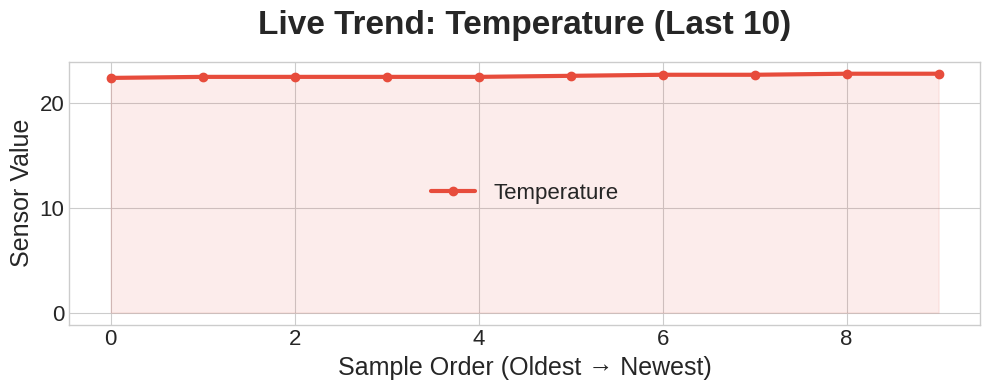

In [43]:


# The rest of your Python code remains the same, as the fix is purely CSS-based.
# ... (Part A, B, and C of your Python code) ...
button_style_fix = """
<style>button {
  display: flex !important;
  justify-content: center !important; /* Centers text horizontally */
  align-items: center !important;   /* Centers text vertically */
}
</style>
"""
# 1. Create the main Tab widget
main_tabs = widgets.Tab()

# 2. Assign the screen widgets to the Tab's children list
# NOTE: The variables main_container_vbox, ui, query_screen_ui, and dash
# must be defined in previous cells for this code block to run.
main_tabs.children = [
    main_container_vbox,
    ui,
    query_screen_ui,
    dash
    # search_engine_tab
]

# 3. Set the titles for each tab (Index starts at 0)
main_tabs.set_title(0, "1. Image Upload & Analysis")
main_tabs.set_title(1, "2. Sensor Data Sampling Control")
main_tabs.set_title(2, "3. MQTT Data Query")
main_tabs.set_title(3, "4. Visual Dashboard")
# Optional: If your original CSS was defined globally and needs to be printed once:
display(HTML(button_style_fix))
display(HTML(css_style))
display(HTML(dash_style))
display(HTML(style_css))
# display(HTML(query_css)) # This line caused the NameError
# 4. Final Display
display(main_tabs)
